First step: create a new conda environment
conda create -n emp python=3.10 

conda activate emp 

conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.6 -c pytorch -c nvidia 

conda install -c conda-forge numpy matplotlib pillow xarray zarr netcdf4 scipy imageio networkx scikit-image s3fs pyproj pyarrow seaborn cartopy tensorboard dask pytorch-lightning=1.7.7 torchmetrics=0.7.3 
pip install earthnet segmentation-models-pytorch 

In [2]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])

In [5]:
# Path of the folders
basepath = Path("/scratch/crobin/earthnet2023_preprocessing/")
train_paths = list(basepath.glob("train/*/*.nc"))
test_paths = list(basepath.glob("test/*/*.nc")) #list(basepath.glob("test/*/*.nc"))
pred_paths = list(Path("/Net/Groups/BGI/scratch/crobin/PythonProjects/EarthNet/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_16.10.2023_absolute_NDVI/preds/iid/").glob("*/*"))
print("len train set: ", len(train_paths))
print("len test set: ", len(test_paths))
print("len prediction set: ", len(pred_paths))

len train set:  748
len test set:  4534
len prediction set:  4534


Select a minicube

In [6]:
pred_path = pred_paths[0]
name = str(pred_path)[-12:]
test_path = list(basepath.glob("test/*/" + name))[0]
print("the prediction path is: ", pred_path)
print("the target path is: ", test_path)

the prediction path is:  /Net/Groups/BGI/scratch/crobin/PythonProjects/EarthNet/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_16.10.2023_absolute_NDVI/preds/iid/Angola/34KEG4402.nc
the target path is:  /scratch/crobin/earthnet2023_preprocessing/test/Angola/34KEG4402.nc


In [8]:
# Load the data
minicube = xr.open_dataset(test_path)
minicube.esawc

AttributeError: 'Dataset' object has no attribute 'esawc'


                10 - Tree cover
                20 - Shrubland
                30 - Grassland
                40 - Cropland
                50 - Built-up
                60 - Bare / sparse vegetation
                70 - Snow and Ice
                80 - Permanent water bodies
                90 - Herbaceous wetland
                95 - Mangroves
                100 - Moss and lichen
                


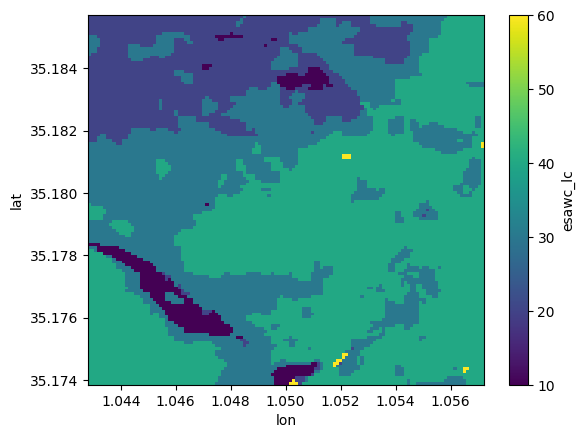

In [7]:
# Plot the elevation map
data = minicube.esawc_lc
yi = data
print(yi.classes)
yi.plot()
plt.show() 

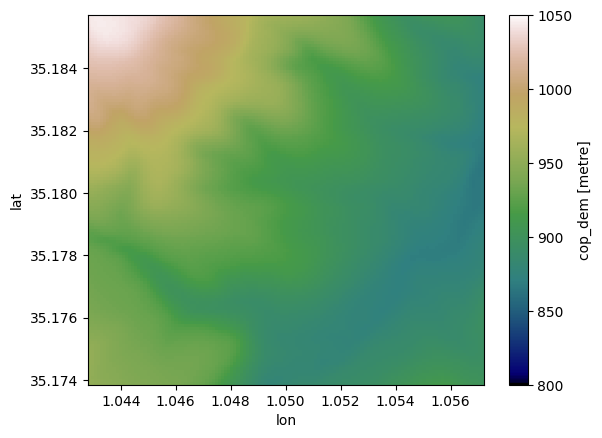

In [35]:
# Plot the elevation map
data = minicube.cop_dem 
yi = data
#print(yi.classes)
yi.plot(cmap='gist_earth', vmin=800, vmax=1050)
plt.show() 

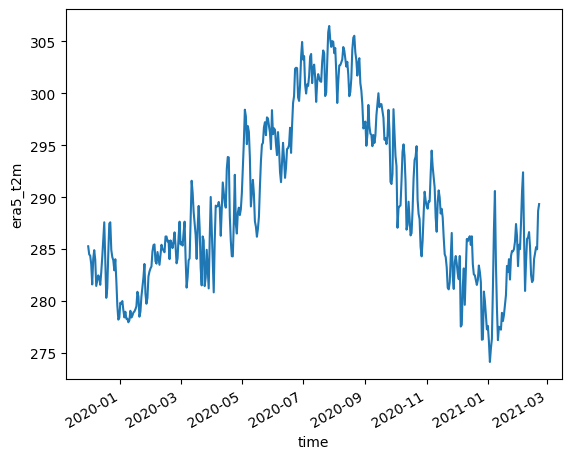

In [8]:
minicube.era5_t2m.plot()

Plot a minicube

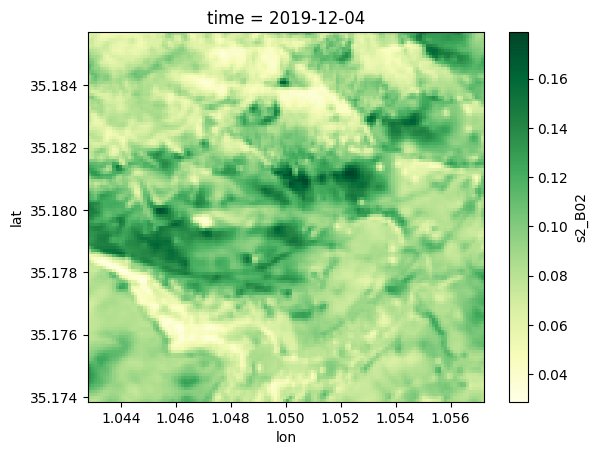

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])
minicube = xr.open_dataset(test_path)
# To plot one of the sentinel-2 band
minicube.s2_B02.isel(time=4).plot(cmap=cmap_veg)

Plot the RGB channels of a minicube

In [24]:
# The rgb channel need to be normalise and enlightened. 
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def brighten(band):
    alpha=1
    beta=0
    return np.clip(alpha*band+beta, 0,255)

/Net/Groups/BGI/scratch/crobin/miniconda3/envs/EarthnetEnv/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


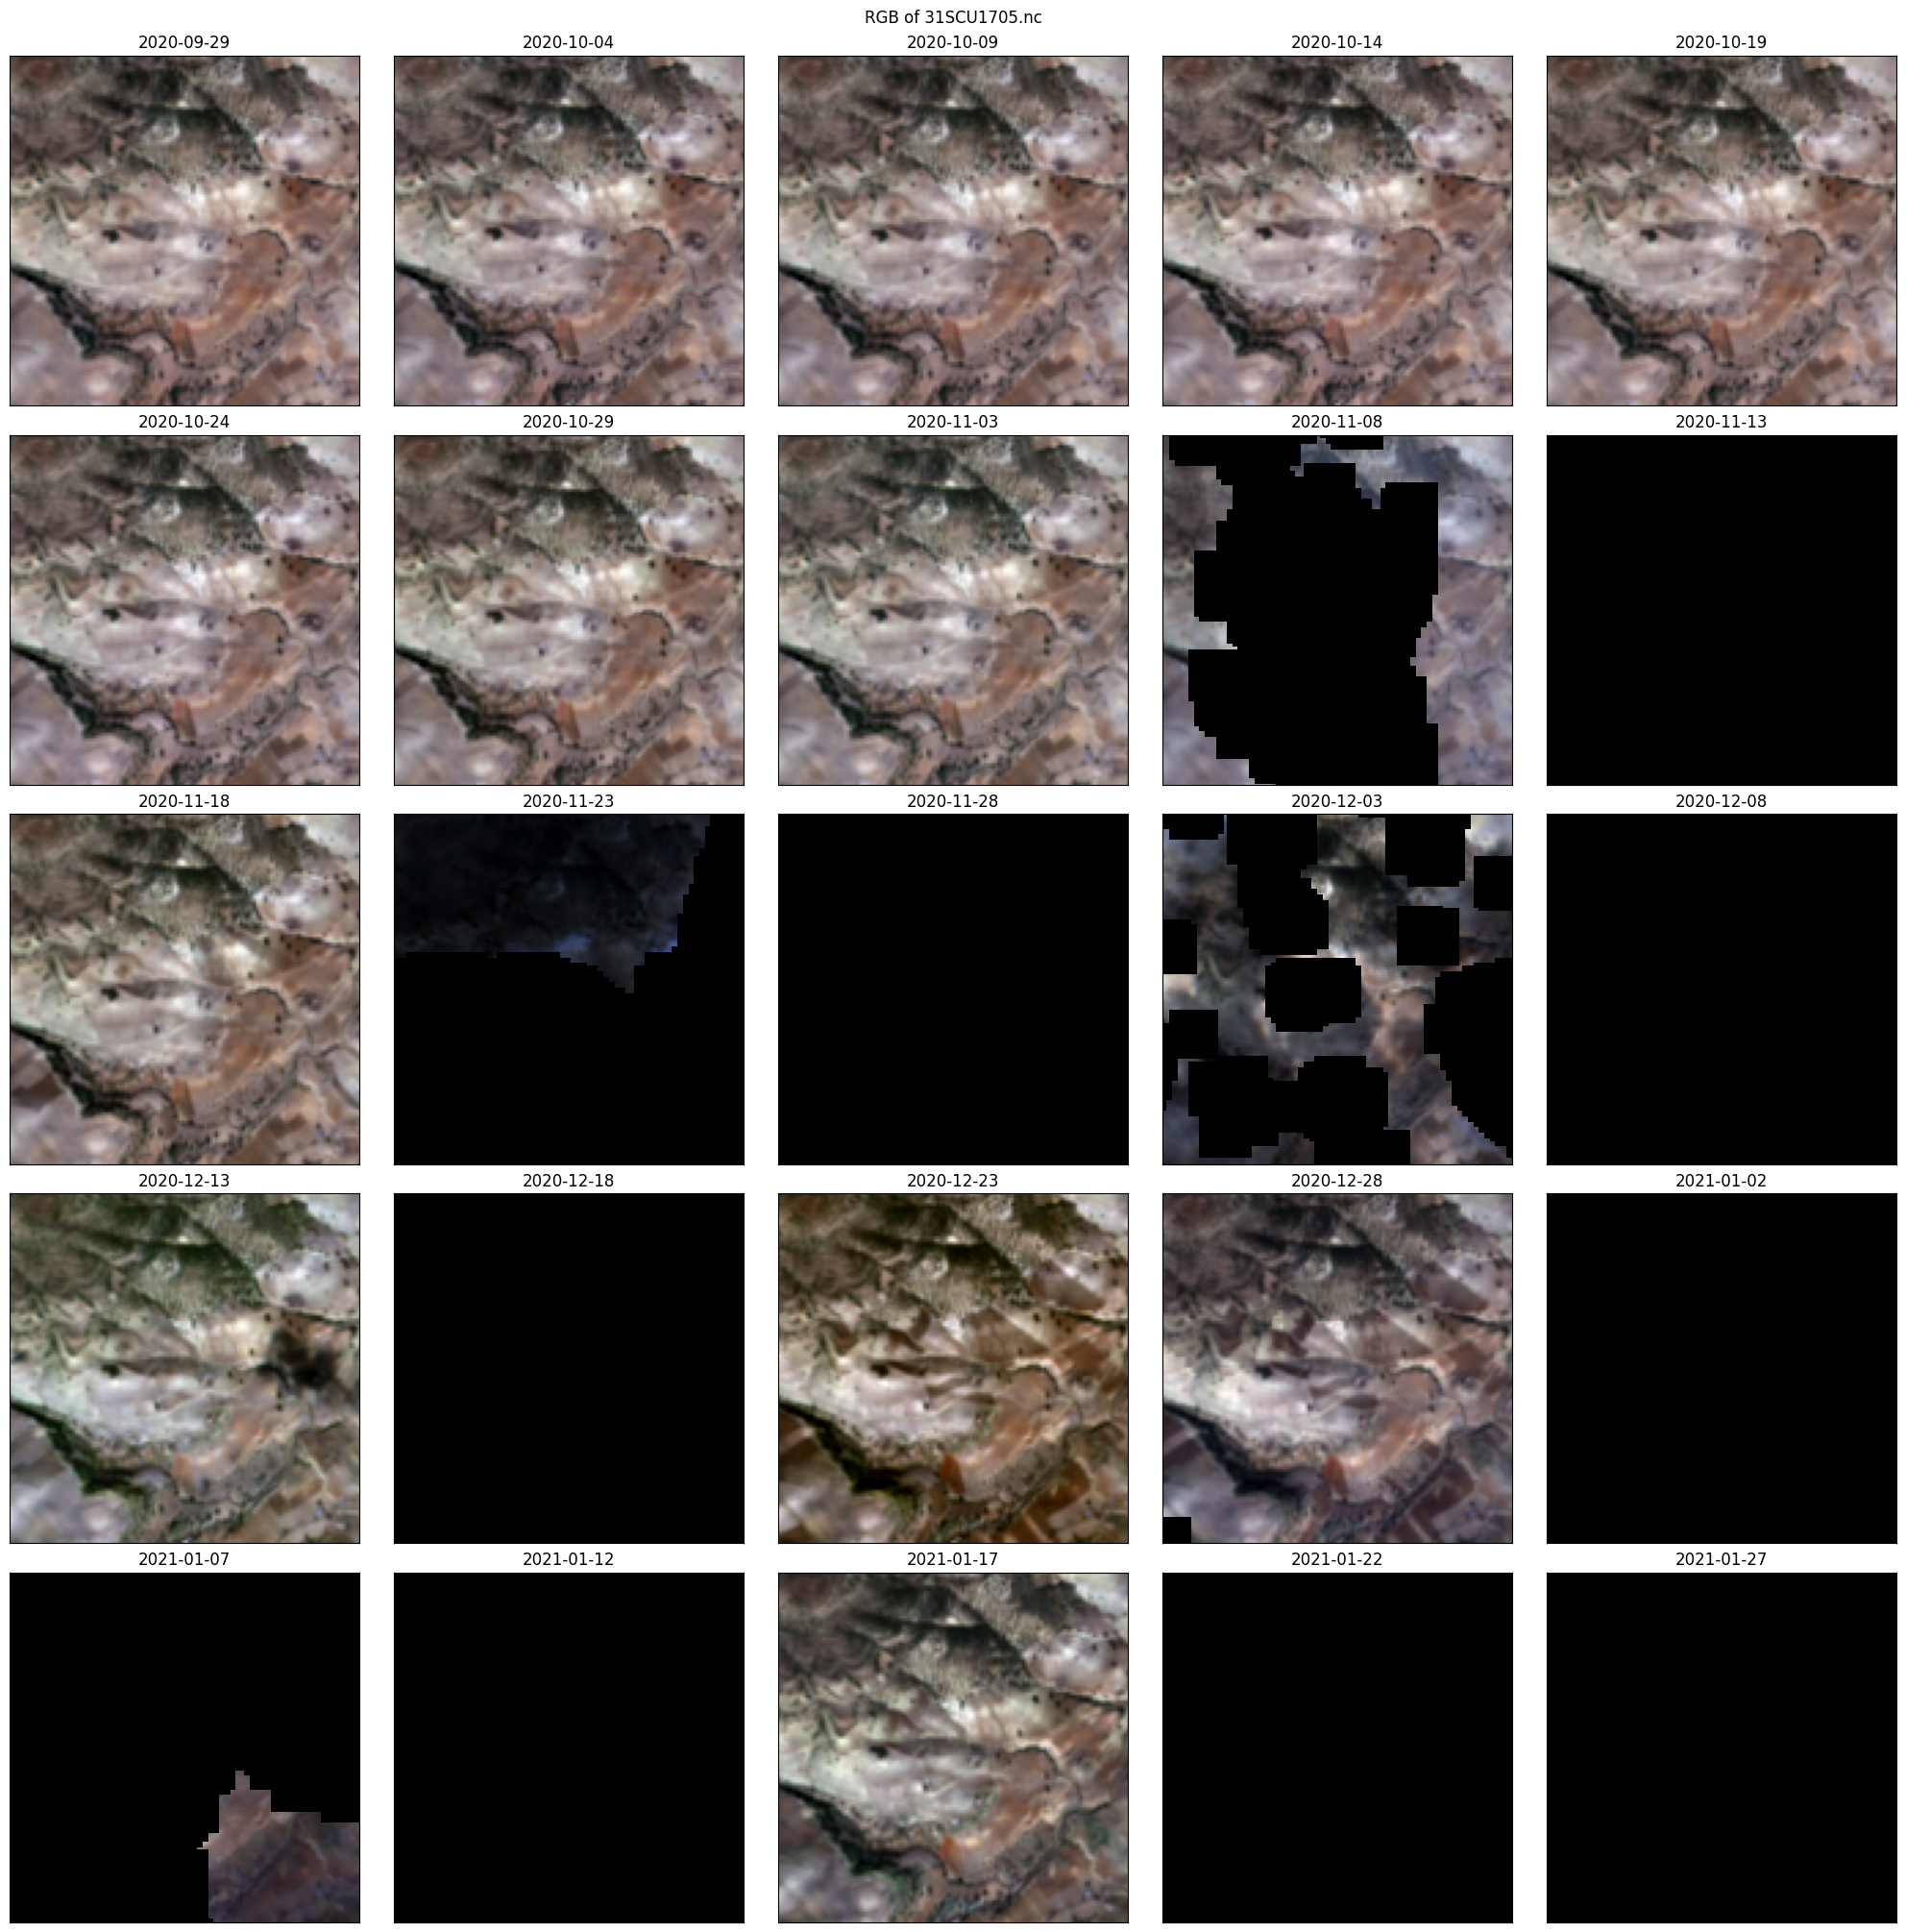

In [25]:
# Load the data
minicube = xr.open_dataset(test_path)

# select the time step with valid values since Sentinel-2 5-daily. Sometimes data can also be missing. 
# Read more about Sentinel-2 
time = np.where(minicube.s2_avail.values == 1)[0]

# Cloud masking
mask = (minicube.s2_mask < 1.0)

fig, axes = plt.subplots(nrows=5, ncols=5, constrained_layout=True, figsize=(20, 20))
fig.suptitle("RGB of " + name)
t= 4 + 60*5 # The first Sentinel-2 image is the 5th values i.e. 4 in python, and the context data of this model is 60 * 5. 
for i in range(5):
    for j in range(5):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)

        red = brighten(normalize(minicube.isel(time=t).s2_B04))
        green = brighten(normalize(minicube.isel(time=t).s2_B03))
        blue = brighten(normalize(minicube.isel(time=t).s2_B02))

        # Remove the cloud masking
        red = np.where(red * mask.isel(time=t) == 0, np.nan, red)
        green = np.where(green * mask.isel(time=t) == 0, np.nan, green)
        blue = np.where(blue * mask.isel(time=t) == 0, np.nan, blue)

        rgb_composite= np.dstack((red, green, blue))
        axes[i,j].imshow(rgb_composite)
        t += 5


Plot the NDVI target

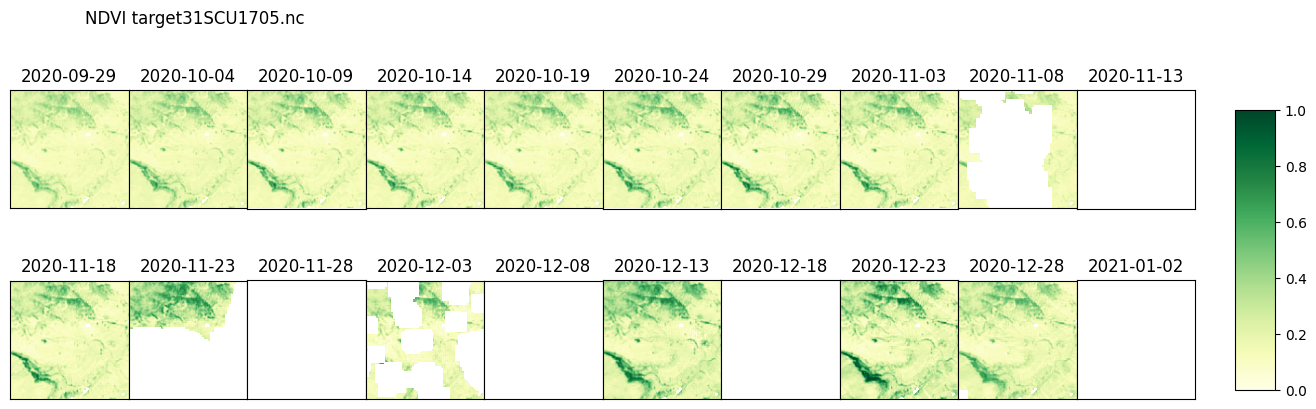

In [4]:
# Load the data
minicube = xr.open_dataset(test_path)
# Define the NDVI
targ = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )
#define the cloud masking
mask = (minicube.s2_mask < 1.0)

# Landcover mask
lc = minicube.esawc_lc
# non-vegetation pixel mask
lc_mask = (lc <= 40) | (lc >= 90) 

# target only on vegetation pixel
targ = targ * mask * lc_mask
targ = np.where(targ == 0, np.nan, targ)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
fig.suptitle("NDVI target" + name,x=0.1, y=1.1)

t= 4 + 60 * 5 # 60 * 5: context period
for i in range(2):
    for j in range(10):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
        im = axes[i,j].imshow(targ[t,...], cmap=cmap_veg, vmin=0, vmax=1)
        t += 5 # non gap filled, a lot of nan values

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0, top=0.99, right=0.6)
cbar_ax = fig.add_axes([0.62, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

Plot the prediction of a minicube

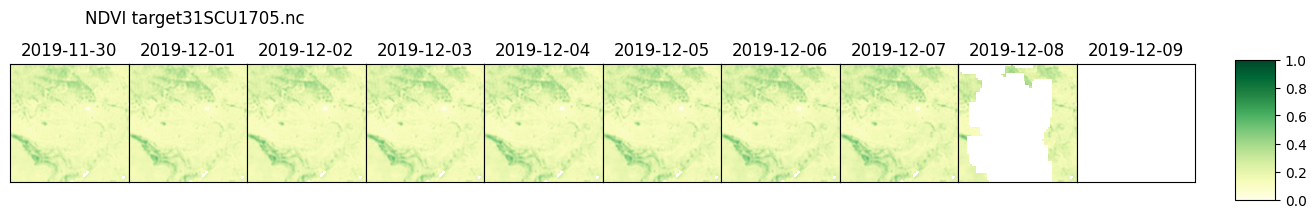

In [9]:
# Load the data
minicube_pred = xr.open_dataset(pred_path)
# Define the NDVI
pred = minicube_pred.ndvi_pred

# target only on vegetation pixel
pred = pred * mask * lc_mask
pred = np.where(pred == 0, np.nan, pred)
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2))
fig.suptitle("NDVI target" + name,x=0.1, y=1.1)
t= 0
for j in range(10):
    axes[j].get_xaxis().set_visible(False)
    axes[j].get_yaxis().set_visible(False)
    axes[j].set_title(minicube.isel(time=t).time.dt.date.values)
    im = axes[j].imshow(pred[t,...], cmap=cmap_veg, vmin=0, vmax=1)
    t += 1 # non gap filled, a lot of nan values

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0, top=0.99, right=0.6)
cbar_ax = fig.add_axes([0.62, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

Compare the prediction of a model to its target

/Net/Groups/BGI/scratch/crobin/miniconda3/envs/EarthnetEnv/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


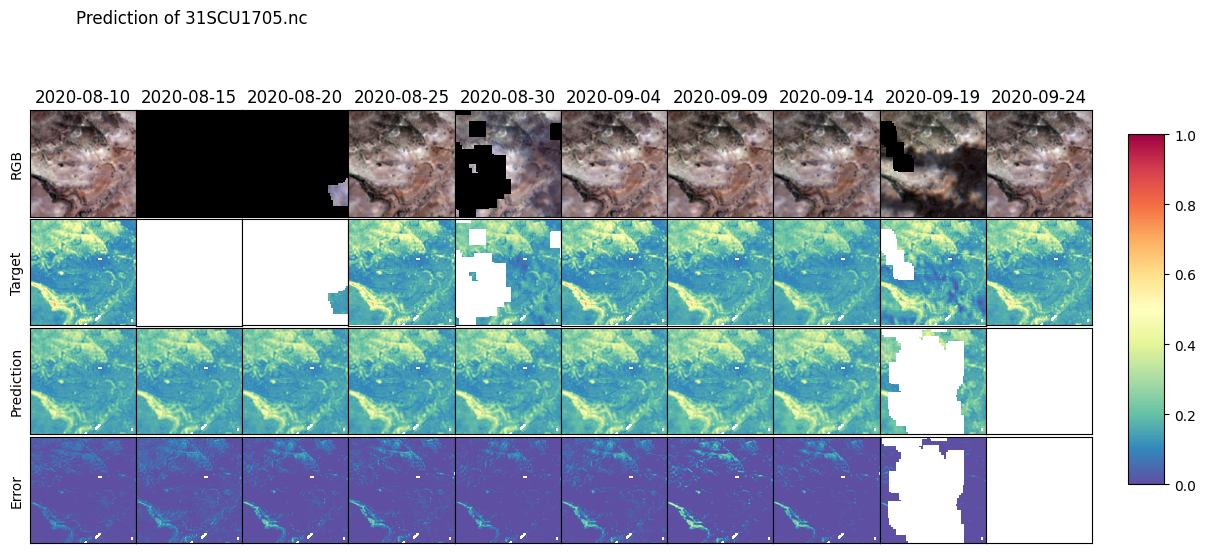

In [38]:
minicube = xr.open_dataset(test_path)
targ = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )
# Cloud mask
mask = (minicube.s2_mask < 1.0)
# Landcover mask
lc = minicube.esawc_lc
lc_mask = (lc <= 40) | (lc >= 90)

# target only on vegetation pixel
targ = targ * mask * lc_mask
targ = np.where(targ == 0, np.nan, targ)

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(18, 5))
fig.suptitle("Prediction of " + name,x=0.1, y=1.1)

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def brighten(band):
    alpha=1
    beta=0
    return np.clip(alpha*band+beta, 0,255)

# Context plot: plot the last 10 frames seen by the model
t= 4 + 50 * 5
i = 0
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
    im = axes[i,j].imshow(targ[t,...], cmap="Spectral_r", vmin=0, vmax=1)
    t += 5 # non gap filled, a lot of nan values
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Context')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

# RGB plot
t= 4 + 50 * 5
i = 0
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
    
    red = brighten(normalize(minicube.isel(time=t).s2_B04))
    green = brighten(normalize(minicube.isel(time=t).s2_B03))
    blue = brighten(normalize(minicube.isel(time=t).s2_B02))

    red = np.where(red * mask.isel(time=t) == 0, np.nan, red)
    green = np.where(green * mask.isel(time=t) == 0, np.nan, green)
    blue = np.where(blue * mask.isel(time=t) == 0, np.nan, blue)

    rgb_composite= np.dstack((red, green, blue))
    axes[i,j].imshow(rgb_composite)
        
    t += 5 
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('RGB')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

# Target plot
t= 4 + 50 * 5
i = 1
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    # axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
    im = axes[i,j].imshow(targ[t,...], cmap="Spectral_r", vmin=0, vmax=1)
    t += 5 # non gap filled, a lot of nan values
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Target')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

# Prediction
pred_cube = xr.open_dataset(pred_path)
pred_cube = pred_cube * mask * lc_mask
pred = np.where(pred_cube.ndvi_pred == 0, np.nan, pred_cube.ndvi_pred)
i = 2
t = 0
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    im = axes[i,j].imshow(pred[t,...], cmap="Spectral_r", vmin=0, vmax=1)
    t += 1
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Prediction')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

i = 3
t1 = 4 + 60 * 5
t2 = 0  
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    error = targ[t1,...] - pred[t2,...] 
    im = axes[i,j].imshow(error, cmap="Spectral_r", vmin=0, vmax=1)
    t1 += 5
    t2 += 1
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Error')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0, top=0.9, right=0.6)
cbar_ax = fig.add_axes([0.62, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

The current prediction are the prediction of the absolute prediction. We also have a model trained to predict only the anomalie to the climatology (i.e. the mean NDVI over 7 years of each place). The dataset is in "/config_interpolation_interpolation". 


In [ ]:
# For the anomalie dataset, the target become: 
targ = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            ) - minicube.msc

# Or, if we want to plot the absolute ndvi:
pred = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            ) + minicube_pred.ndvi_pred